In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

In [2]:
from skimage import io

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import os

In [5]:
num_classes=2

batch_size=20

In [6]:
from torch.utils.data import Dataset
import pandas as pd

class JSRTdataset(Dataset):
  def __init__(self,csv_file,root_dir,transform=None):
    self.annotations=pd.read_csv(csv_file).drop("Unnamed: 0",axis=1)
    #print(5)
    self.root_dir=root_dir
    self.transform=transform
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
    image=io.imread(img_path)
    #print(image)
    y_label=torch.tensor(self.annotations.iloc[index,1])
    if not torch.is_tensor(image):
        image=torchvision.transforms.functional.to_tensor(image)    
    if self.transform:
      '''if not torch.is_tensor(image):
        image=torchvision.transforms.functional.to_tensor(image)'''
      image=self.transform(image)
      '''image=torchvision.transforms.functional.resize(img=image,size=[255,255])
      image=torchvision.transforms.functional.normalize(tensor=image,mean=0.5,std=0.5)'''
    return (image,y_label)




In [7]:
train_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/train_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images")

test_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/test_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images")

train_loader=DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [8]:
# Normalisation
num_pixels_train=len(train_set)*2048*2048

total_sum=0
for batch in train_loader: total_sum += batch[0].sum()
mean = total_sum/num_pixels_train

sum_of_squared_error = 0
for batch in train_loader: sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error/num_pixels_train)

print(mean,std)

tensor(0.5950) tensor(0.2735)


In [9]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std)
])


In [10]:
train_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/train_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images",transform=transformations)

test_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/test_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images",transform=transformations)

train_loader=DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

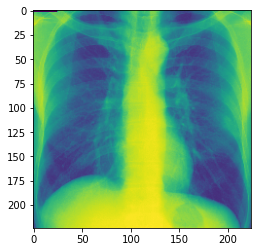

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
for images , labels in train_set:
  plt.imshow(images[0])
  plt.show()
  break

In [12]:
for images , labels in train_set:
  print(images.shape)
  print(images.dtype)
  break

torch.Size([1, 224, 224])
torch.float32


In [13]:
for i,data in enumerate(train_loader):
  imaged,labeld = data
  print(labeld)
  break

tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1])


In [14]:
dataiter=iter(train_loader)
images,labels=dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels.shape)
print(labels[0].item())

torch.Size([20, 1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([20])
0


torch.Size([20, 1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([20])
0


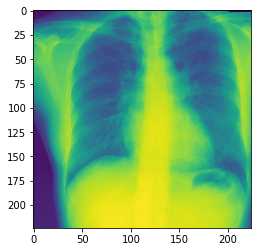

In [15]:
images,labels=dataiter.next()
print(images.shape)
print(images[0].shape)
print(labels.shape)
print(labels[0].item())
plt.imshow(images[0][0])
plt.show()

torch.Size([20, 1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([20])
0


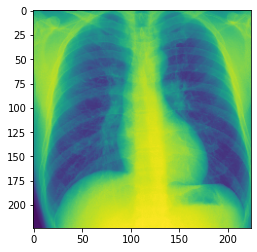

In [16]:
images,labels=dataiter.next()
print(images.shape)
print(images[0].shape)
print(labels.shape)
print(labels[0].item())
plt.imshow(images[0][0])
plt.show()

In [17]:
class LeNet_for_1channel(nn.Module):
  def __init__(self):
    super(LeNet_for_1channel,self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(1,6,5,padding=(1,1),stride=(4,4)), # (40,1,244,244)-->(40,6,60,60)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2), # (40,6,60,60) --> (20,6,30,30)
        nn.Conv2d(6,16,3,padding=(1,1),stride=(2,2)), # (20,6,30,30) --> (20,16,14,14)
        nn.Tanh(),
        nn.AvgPool2d(2,stride=2) # (20,16,14,14) -->  (20,16,7,7) 
    )
    self.fc_model = nn.Sequential(
        nn.Linear(784,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,2),
        nn.Softmax()
    )
  def forward(self,x):
    x=self.cnn_model(x)
    x=x.view(x.size(0),-1)
    x=self.fc_model(x)
    return x

In [18]:
net_LeNet = LeNet_for_1channel().to(device)

In [19]:
#sm=torch.nn.Softmax()

In [20]:
def evaluation(dataloader):
  total,correct = 0,0
  model_predictions=[]
  data_labels=[]
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device),labels.to(device)
    outputs = net_LeNet(inputs)
    _,pred=torch.max(outputs.data,1)
    model_predictions.append(torch.transpose(outputs.data, 0,1)[1].cpu().numpy())
    data_labels.append(labels.cpu().numpy())
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  return 100*correct/total,model_predictions,data_labels

In [21]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net_LeNet.parameters())
#opt2 = optim.Adam(UNet_model.parameters())

In [22]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 30

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.82 µs


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 0/30, Test acc: 60.00, Train acc : 59.39
Epoch : 1/30, Test acc: 60.00, Train acc : 59.39
Epoch : 2/30, Test acc: 54.00, Train acc : 67.01
Epoch : 3/30, Test acc: 60.00, Train acc : 61.93
Epoch : 4/30, Test acc: 50.00, Train acc : 68.53
Epoch : 5/30, Test acc: 62.00, Train acc : 64.97
Epoch : 6/30, Test acc: 52.00, Train acc : 67.51
Epoch : 7/30, Test acc: 54.00, Train acc : 67.01
Epoch : 8/30, Test acc: 56.00, Train acc : 65.48
Epoch : 9/30, Test acc: 52.00, Train acc : 70.05
Epoch : 10/30, Test acc: 52.00, Train acc : 69.04
Epoch : 11/30, Test acc: 54.00, Train acc : 69.54
Epoch : 12/30, Test acc: 62.00, Train acc : 73.10
Epoch : 13/30, Test acc: 62.00, Train acc : 72.59
Epoch : 14/30, Test acc: 60.00, Train acc : 67.01
Epoch : 15/30, Test acc: 60.00, Train acc : 69.54
Epoch : 16/30, Test acc: 60.00, Train acc : 70.05
Epoch : 17/30, Test acc: 58.00, Train acc : 71.57
Epoch : 18/30, Test acc: 64.00, Train acc : 73.10
Epoch : 19/30, Test acc: 60.00, Train acc : 69.54
Epoch : 20

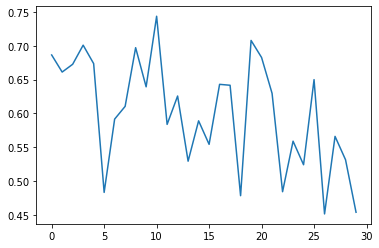

In [23]:
for epoch in range(max_epochs):
  predictions=[]
  y_labels=[]
  for i , data in enumerate(train_loader,0):
    inputs,labels =data
    inputs, labels = inputs.to(device),labels.to(device)
    opt.zero_grad()
    #opt2.zero_grad()
    outputs = net_LeNet(inputs)
    #print(outputs)
    #print("labels : ",labels)

    loss =loss_fn(outputs,labels)  #target.squeeze(1)
    predictions.append(outputs)
    y_labels.append(labels)
    loss.backward()
    opt.step()
    #opt2.step()
    loss_arr.append(loss.item())
  loss_epoch_arr.append(loss.item())
  test_acc,test_predictions,test_labels=evaluation(test_loader)
  train_acc,train_predictions,train_labels=evaluation(train_loader)
  print("Epoch : %d/%d, Test acc: %0.2f, Train acc : %0.2f" % (epoch,max_epochs,test_acc,train_acc))

plt.plot(loss_epoch_arr)
plt.show()

In [24]:
loss.item()

0.45391055941581726

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [27]:
import numpy as np

In [28]:
complete_training_batch_labels=np.array([])
for i in train_labels:
  complete_training_batch_labels=np.append(complete_training_batch_labels,i)

complete_test_batch_labels=np.array([])
for i in test_labels:
  complete_test_batch_labels=np.append(complete_test_batch_labels,i)

complete_training_batch_predictions=np.array([])
for i in train_predictions:
  complete_training_batch_predictions=np.append(complete_training_batch_predictions,i)

complete_test_batch_predictions=np.array([])
for i in test_predictions:
  complete_test_batch_predictions=np.append(complete_test_batch_predictions,i)



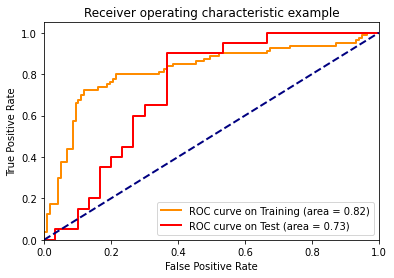

In [29]:
fpr_training, tpr_training, thresholds_training = roc_curve(complete_training_batch_labels, complete_training_batch_predictions, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(complete_test_batch_labels, complete_test_batch_predictions, pos_label=1)
roc_auc_training = auc(fpr_training, tpr_training)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_training, tpr_training, color='darkorange',
         lw=lw, label='ROC curve on Training (area = %0.2f)' % roc_auc_training)
plt.plot(fpr_test, tpr_test, color='red',
         lw=lw, label='ROC curve on Test (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")



plt.show()

Non Malignant : f1=0.585 auc=0.519


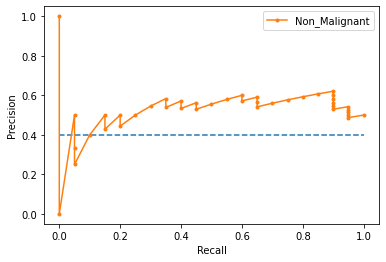

In [34]:
from sklearn.metrics import precision_recall_curve

train_precision, train_recall, _ = precision_recall_curve(complete_training_batch_labels,
                               complete_training_batch_predictions, pos_label=1)
test_precision,test_recall,_ = precision_recall_curve(complete_test_batch_labels, 
                                                complete_test_batch_predictions, pos_label=1)

train_f1,train_auc = f1_score(complete_training_batch_labels,
                               np.round(complete_training_batch_predictions)),auc(train_recall, train_precision)
      
test_f1,test_auc = f1_score(complete_test_batch_labels,
                               np.round(complete_test_batch_predictions)),auc(test_recall, test_precision)

print('Non Malignant : f1=%.3f auc=%.3f' % (test_f1,test_auc))
# plot the precision-recall curves
Malignant = len(complete_test_batch_labels[complete_test_batch_labels==1]) / len(complete_test_batch_labels)
plt.plot([0, 1], [Malignant, Malignant], linestyle='--')
plt.plot(test_recall, test_precision, marker='.', label='Non_Malignant')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [31]:
#torch.save(net_LeNet.state_dict(), 'new_LeNet_with_softmax.pt')